# NanoDet-Plus Model Training

As described in the paper by Chen & Duan the NanoDet pretrained model provided on GitHub by Rangi Lyu (https://github.com/RangiLyu/nanodet) can be used for fall detection on a mobile robot. [1]

The model discussed in the paper has already been superseded by the NanoDet-Plus model with added assign guidance module and dynamic soft label assigner to improve the mean Average Precision (mAP) with only a little cost, according to the GitHub author. So the new model will be further trained for fall detection in this notebook.

In the following the required libraries will be installed and a model overview of the used model will be given. Then the set up of the Google Colab will be done. Afterwards the model will be cloned and set up according to the instructions of the GitHub site. The data preparation will be explained and the configuration will be performed afterwards. Then the model will be trained and finally converted to an ONNX model to further be able to convert it into a TensorFlow Lite model.

---


[1]  Chen, Guang, and Xiaohui Duan. “Vision-Based Elderly Fall Detection Algorithm for Mobile Robot.” 2021 IEEE 4th International Conference on Electronics Technology (ICET), 2021, pp. 1197–202, https://doi.org/10.1109/ICET51757.2021.9450950.

## Set up Libraries & mount Google Drive

In [1]:
# Import libraries
import tensorflow as tf
import IPython
import torch
import shutil
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from psutil import virtual_memory
from google.colab import drive
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import HtmlFormatter

In [2]:
# Mount google drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


## Model Overview

The NanoDet-Plus-m model is chosen since it is the closest comparable version to the NanoDet model that Chen and Duan used in their study and secondly, it is one of the smallest models with good latency and a still acceptable mean average precision, especially compared to YOLOv4-Tiny, YOLOX-Nano and MobileDet.

The model parameter are as follows:

*   Model: NanoDet-Plus-m	
*   Resolution: 320*320	
*   mAP val: 27.0	
*   CPU Latency (i7-8700): 5.25ms	
*   ARM Latency (4xA76): 11.97ms	
*   FLOPS: 0.9G	
*   Params: 1.17M	
*   Model Size: 2.3MB(FP16) | 1.2MB(INT8)

The pretrained weights (checkpoint) are used and as in the paper by Chen & Duan the backbone will be trained with ShuffleNetV2 1.0x and 0.5x.

The following chart shows an overview of the construction of the NanoDet-Plus model which is explained in further detail in the according paper to this notebook.

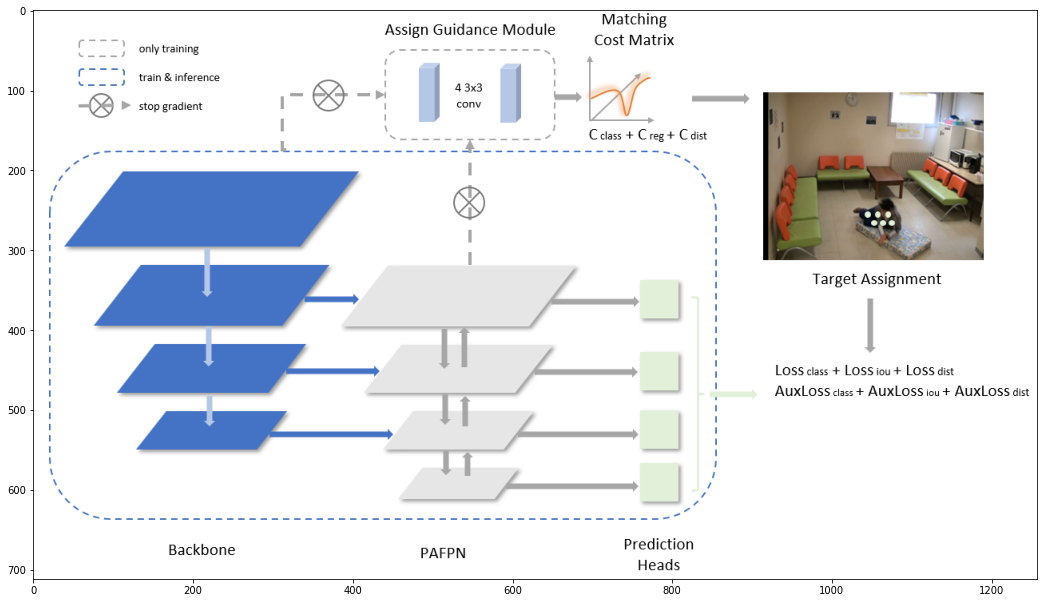

<Figure size 1296x1296 with 0 Axes>

In [ ]:
# Show image
plt.figure(figsize=(18,18))
img = mpimg.imread('/content/drive/MyDrive/MasterThesis/NanoDet/Pictures/NanoDet-Plus.png')
imgplot = plt.imshow(img)
fig = plt.figure(figsize=(18, 18))
plt.show()

## Google Colab Setup

A CUDA (Compute Unified Device Architecture) is required to further train the pre-trained weights. A CUDA is a technology and programming interface developed by NVIDIA that allows the processing power of graphics processing units (GPUs) to be used for applications. Due to the high computing power and parallel operation of the GPUs, enormous gains in performance can be achieved in certain applications.

Check if a GPU is available:

In [14]:
# Check GPU
print(tf.test.gpu_device_name())

/device:GPU:0


Check details of the GPU provided by Google and CUDA version 11.2:

In [15]:
# Retain GPU info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Jul  1 18:19:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    35W / 250W |    375MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Check the random access memory provided by Google.

In [16]:
# Retain RAM info
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


Check the contents of the drive and the subfolders:

In [17]:
# Check folders
!ls /content/drive/MyDrive/MasterThesis/

FallDataset  NanoDetPrediction.ipynb  Questionnaire
NanoDet      NanoDetTraining.ipynb    VideoConverter.ipynb


## NanoDet-Plus Setup

Clone the nanodet GitHub repository:

In [3]:
# Clone repository
!git clone https://github.com/RangiLyu/nanodet.git

Cloning into 'nanodet'...
remote: Enumerating objects: 2515, done.
remote: Total 2515 (delta 0), reused 0 (delta 0), pack-reused 2515
Receiving objects: 100% (2515/2515), 5.23 MiB | 23.50 MiB/s, done.
Resolving deltas: 100% (1472/1472), done.


And install the requirements according to the instructions:

In [4]:
# Install requirements
%cd nanodet
!pip install -r requirements.txt

/content/nanodet
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79 kB 3.9 MB/s 
     |████████████████████████████████| 13.1 MB 10.3 MB/s 
     |████████████████████████████████| 585 kB 93.6 MB/s 
     |████████████████████████████████| 419 kB 97.6 MB/s 
     |████████████████████████████████| 117 kB 69.1 MB/s 
     |████████████████████████████████| 596 kB 91.3 MB/s 
     |████████████████████████████████| 140 kB 85.4 MB/s 
     |████████████████████████████████| 1.1 MB 73.5 MB/s 
     |████████████████████████████████| 498 kB 76.6 MB/s 
     |████████████████████████████████| 232 kB 91.0 MB/s 
     |████████████████████████████████| 5.2 MB 66.8 MB/s 
     |████████████████████████████████| 271 kB 93.5 MB/s 
     |████████████████████████████████| 94 kB 4.4 MB/s 
     |████████████████████████████████| 144 kB 79.7 MB/s 
     |████████████████████████████████| 51 kB 8.2 MB/s 
  Created wheel for

After restarting the runtime and installing the libraries again the setup of nanodet can take place.

In [2]:
# Check content
!ls /content/nanodet

config		   demo_libtorch  demo_openvino  nanodet	   setup.py
demo		   demo_mnn	  docs		 README.md	   tests
demo_android_ncnn  demo_ncnn	  LICENSE	 requirements.txt  tools


In [2]:
# Set up NanoDet
%cd /content/nanodet
!python setup.py develop

/content/nanodet
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:484: UserWarning: Normalizing '1.0.0-alpha' to '1.0.0a0'
  warnings.warn(tmpl.format(**locals()))
running develop
running egg_info
creating nanodet.egg-info
writing nanodet.egg-info/PKG-INFO
writing dependency_links to nanodet.egg-info/dependency_links.txt
writing top-level names to nanodet.egg-info/top_level.txt
writing manifest file 'nanodet.egg-info/SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'nanodet.egg-info/SOURCES.txt'
running build_ext
Creating /usr/local/lib/python3.7/dist-packages/nanodet.egg-link (link to .)
Adding nanodet 1.0.0a0 to easy-install.pth file

Installed /content/nanodet
Processing dependencies for nanodet==1.0.0a0
Finished processing dependencies for nanodet==1.0.0a0


Check whether the module has been found:

In [3]:
import nanodet
nanodet.__version__

'1.0.0-alpha'

# Data Preparation

For the training of falls Chen & Duan (2021) use the UR Fall Detection Dataset: http://fenix.univ.rzeszow.pl/~mkepski/ds/uf.html as mentioned in their paper. Since they labelled it manually and did not provide the information on which videos or how they labeled each frame, the fall dataset from Im-Via, which has labels already provided is taken for this research: https://imvia.u-bourgogne.fr/en/database/fall-detection-dataset-2.html. [1]

Since the annotations provided with that dataset are not in the required COCO dataformat, the data will be brepared first unsing the "VideoConverter.ipynb" notebook. Once the conversion has taken place and the folders with the frames and COCO annotations have been created, they can be reused for different trainings of the NanoDet-Plus model and do not have to be created again!

Having prepared the data with the "VideoConverter.ipynb" notebook the training can be configured.

Note: for this training the frames and annotations for the different fall definitions were stored using the same folder names. So before training the "lie" models, the foldernames have to be switched.


# Training Configuration

For the training the pre-trained checkpoint weights of the NanoDet-Plus-m model were downloaded from the GitHub site (https://drive.google.com/file/d/1YvuEhahlgqxIhJu7bsL-fhaqubKcCWQc/view?usp=sharing) as well as the according YAML file called "nanodet-plus-m_320.yml" (https://github.com/RangiLyu/nanodet/blob/main/config/nanodet-plus-m_320.yml) and uploaded into a folder on Google Colab.

The input parameters in the YAML file were changed to train the NanoDet-Plus model for the two classes "fall" and activities of daily living "ADL" and the storage paths were changed to the Google Drive paths. 

Depending on which training should be performed, one of the 6 YAML files provided on the GitHub for this study can be chosen in the following:

In [5]:
# Open and format configuration file
with open('/content/drive/MyDrive/MasterThesis/NanoDet/ShuffleNetV2-05x/nanodet-plus-m_320_AdamW_ShuffleNetV2-05x_fall.yml') as f:
    code = f.read()

formatter = HtmlFormatter()
IPython.display.HTML('<style type="text/css">{}</style>{}'.format(
    formatter.get_style_defs('.highlight'),
    highlight(code, PythonLexer(), formatter)))

To get an overview of the pre-trained weights, they can be loaded and printed.

In [ ]:
# Load weights
weights = torch.load('/content/drive/MyDrive/MasterThesis/NanoDet/nanodet-plus-m_320_checkpoint.ckpt')

In [ ]:
# Show weights
print(weights)

Since the output of the weights is extremely long, a screenshot is included here for the sake of clarity.

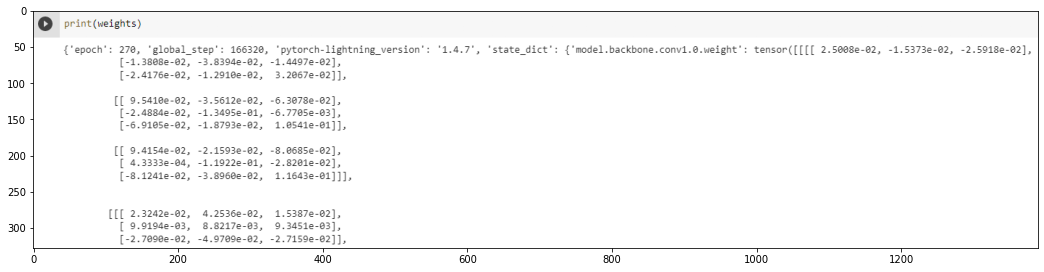

In [ ]:
# Show image of weights
plt.figure(figsize=(18,18))
img = mpimg.imread('/content/drive/MyDrive/MasterThesis/NanoDet/Pictures/weights_nanodet-plus-m_320.png')
imgplot = plt.imshow(img)
plt.show()

# Train NanoDet-Plus Model

After checking the configuration, the same configuration file should be used for training in the following. During several training phases it was noticed that Google Colab has sometimes problems retaining all the training imgages from Google Drive and the training of the model is aborted. In this case, the log files in the target folder should be deleted and the training should be started over again.

Check whether all required folders are available.

In [6]:
# Check folders
!ls '/content/drive/MyDrive/MasterThesis/FallDataset/'

AllFrames	     ImViaFallDataset	 URFallDatasetSample
Annotation_files     TestFrames		 ValidationFrames
CocoAnnotations      TrainingFrames	 ValidationFrames_lie
CocoAnnotations_lie  TrainingFrames_lie  Videos


Start the training with the according configuration file.

In [ ]:
# Train NanoDet-Plus model
!python '/content/nanodet/tools/train.py' '/content/drive/MyDrive/MasterThesis/NanoDet/ShuffleNetV2-05x/nanodet-plus-m_320_AdamW_ShuffleNetV2-05x_fall.yml'

[NanoDet][07-01 18:25:57]INFO:Setting up data...
loading annotations into memory...
Done (t=0.39s)
creating index...
index created!
loading annotations into memory...
Done (t=0.78s)
creating index...
index created!
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
[NanoDet][07-01 18:25:58]INFO:Creating model...
model size is  0.5x
init weights...
Downloading: "https://download.pytorch.org/models/shufflenetv2_x0.5-f707e7126e.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x0.5-f707e7126e.pth
100% 5.28M/5.28M [00:00<00:00, 97.3MB/s]
=> loading pretrained model https://download.pyt

After the model is trained, the target folder contains the log files as well as the best model and it's evaluation metrics.

## Convert PyTorch to ONNX

Since PyTorch has no lite version for implementation on single-board computers, the PyTorch model needs to be converted. ONNX is an open format which allows to convert the model further into different formats for other frameworks. For there is no direct transformation of a PyTorch model into TensorFlow Lite, the model will be transformed into ONNX format, then to TensorFlow (TF) format and afterwards to TensorFlow Lite (TF Lite).

As the post-processing of the NanoDet-Plus model is not provided for the TensorFlow Lite framework and it was found to be quite extensive at a later stage, the ONNX model was converted for the ncnn framework via the online platform: https://convertmodel.com/

There is a provided script for conversion of the NanoDet-Plus model called "export_onnx.py". For a conversion to the ncnn model at a later stage, the parameter "export_params=True" will be added to the torch.onnx.export function:

    torch.onnx.export(
        model,
        dummy_input,
        output_path,
        verbose=True,
        keep_initializers_as_inputs=True,
        opset_version=11,
        input_names=["data"],
        output_names=["output"],
        export_params=True,
    )

The opset version will remain at 11. 

Afterwards the export can be executed with the information of the according configuration file, the best model checkpoint weights and the path and name of where the ONNX model shall be stored.

In [4]:
# Export to ONNX format
!python '/content/nanodet/tools/export_onnx.py' \
--cfg_path '/content/drive/MyDrive/MasterThesis/NanoDet/ShuffleNetV2-05x/nanodet-plus-m_320_AdamW_ShuffleNetV2-05x_fall.yml' \
--model_path '/content/drive/MyDrive/MasterThesis/NanoDet/ShuffleNetV2-05x/SaveTraining_AdamW_fall/model_best/model_best.ckpt' \
--out_path '/content/drive/MyDrive/MasterThesis/NanoDet/ShuffleNetV2-05x/SaveTraining_AdamW_fall/nanodet_AdamW_ShuffleNetV2-05x_fall.onnx'

model size is  0.5x
init weights...
Downloading: "https://download.pytorch.org/models/shufflenetv2_x0.5-f707e7126e.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x0.5-f707e7126e.pth
100% 5.28M/5.28M [00:00<00:00, 60.9MB/s]
=> loading pretrained model https://download.pytorch.org/models/shufflenetv2_x0.5-f707e7126e.pth
Finish initialize NanoDet-Plus Head.
/content/nanodet/nanodet/model/backbone/shufflenetv2.py:18: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  channels_per_group = num_channels // groups
graph(%data : Float(1, 3, 320, 256, strides=[245760, 81920, 256, 1], requires_grad=0, device=cpu),
      %head.gfl_cls.0.weight : Float(14, 96, 1, 1, st

This model can be taken and transformed into any other required format of the supported tools.

## Convert ONNX model to TensorFlow

As mentioned above, ncnn was later adopted as the framework for the implementation on the Raspberry Pi, however for the sake of completeness the implementation in TensorFlow and TensorFLow Lite and is given below.

First the GitHub repository has to be cloned and installed.



In [5]:
# Clone GitHub repository
!git clone https://github.com/onnx/onnx-tensorflow.git && cd onnx-tensorflow

Cloning into 'onnx-tensorflow'...
remote: Enumerating objects: 6513, done.
remote: Counting objects: 100% (462/462), done.
remote: Compressing objects: 100% (200/200), done.
remote: Total 6513 (delta 322), reused 378 (delta 258), pack-reused 6051
Receiving objects: 100% (6513/6513), 1.98 MiB | 14.46 MiB/s, done.
Resolving deltas: 100% (5049/5049), done.


In [6]:
# Install transformer
%cd onnx-tensorflow
!pip install -e .

/content/nanodet/onnx-tensorflow
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/nanodet/onnx-tensorflow
     |████████████████████████████████| 1.1 MB 5.0 MB/s 
  Running setup.py develop for onnx-tf


When converting PyTorch models to TensorFlow a RuntimeError "pytorch_half_pixel mode unsupported" can occur. In order to fix this the code from Fabio Romagnolo is taken from https://github.com/onnx/onnx-tensorflow/issues/632#issuecomment-1151188333 and slightly adapted to run for the NanoDet-Plus model in the following.

In [7]:
# Copy fix file from Google Drive to nanodet folder
shutil.copy('/content/drive/MyDrive/MasterThesis/NanoDet/onnx_nodes_fix.py', '/content/nanodet/onnx_nodes_fix.py')

'/content/nanodet/onnx_nodes_fix.py'

In [8]:
# Create new ONNX model with fixed nodes
!python /content/nanodet/onnx_nodes_fix.py \
--model_path '/content/drive/MyDrive/MasterThesis/NanoDet/ShuffleNetV2-05x/SaveTraining_AdamW_fall/nanodet_AdamW_ShuffleNetV2-05x_fall.onnx' \
--out_path '/content/drive/MyDrive/MasterThesis/NanoDet/ShuffleNetV2-05x/SaveTraining_AdamW_fall/nanodet_AdamW_ShuffleNetV2-05x_fall_node_fix.onnx'

Loading Model: /content/drive/MyDrive/MasterThesis/NanoDet/ShuffleNetV2-05x/SaveTraining_AdamW_fall/nanodet_AdamW_ShuffleNetV2-05x_fall.onnx
Fixing Resize nodes...
Creating new fixed graph...
Creating new fixed model...
Saving new model as: /content/drive/MyDrive/MasterThesis/NanoDet/ShuffleNetV2-05x/SaveTraining_AdamW_fall/nanodet_AdamW_ShuffleNetV2-05x_fall_node_fix.onnx
Model saved to: /content/drive/MyDrive/MasterThesis/NanoDet/ShuffleNetV2-05x/SaveTraining_AdamW_fall/nanodet_AdamW_ShuffleNetV2-05x_fall_node_fix.onnx


After the nodes are fixed the model can be loaded and prepared for the conversion to TensorFlow.

In [9]:
# Load model
import onnx
onnx_model = onnx.load('/content/drive/MyDrive/MasterThesis/NanoDet/ShuffleNetV2-05x/SaveTraining_AdamW_fall/nanodet_AdamW_ShuffleNetV2-05x_fall_node_fix.onnx') # onnx model

In [10]:
# Prepare model
from onnx_tf.backend import prepare
tf_rep = prepare(onnx_model)

In [11]:
# Determine target path
tf_mode_path = '/content/drive/MyDrive/MasterThesis/NanoDet/ShuffleNetV2-05x/SaveTraining_AdamW_fall'

Now the model can be converted with the follwing function.

In [12]:
# Create and save TensorFlow model
tf_rep.export_graph(tf_mode_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/MasterThesis/NanoDet/ShuffleNetV2-05x/SaveTraining_AdamW_fall/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/MasterThesis/NanoDet/ShuffleNetV2-05x/SaveTraining_AdamW_fall/assets


This will save the TF model as saved_model.pb

## TensorFlow to TensorFlow Lite

From TensorFlow the model can now be converted into a TensorFlow Lite model.

In [13]:
# Path and name of model
tflite_model_path = '/content/drive/MyDrive/MasterThesis/NanoDet/ShuffleNetV2-05x/SaveTraining_AdamW_fall/nanodet_AdamW_ShuffleNetV2-05x_fall.tflite'


In [14]:
# Convert model
converter = tf.lite.TFLiteConverter.from_saved_model(tf_mode_path)
tflite_model = converter.convert()

# Save model
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

The TensorFlow Lite model is now saved and the inference can be checked.

## TF Lite Model Inference

In [15]:
import numpy as np
import tensorflow as tf
from PIL import Image

# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# get_tensor() returns a copy of the tensor data
# use tensor() in order to get a pointer to the tensor
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[[ 1.1798773e-03  2.2491585e-03 -2.3527467e+00 ... -4.3942428e+00
   -3.4414794e+00 -3.2892973e+00]
  [ 1.4547950e-03  4.5451857e-03 -2.9598262e+00 ... -4.9291387e+00
   -4.0302544e+00 -2.7866426e+00]
  [ 1.2297883e-03  4.2066118e-03 -3.0047898e+00 ... -4.7766423e+00
   -3.6552653e+00 -3.0258529e+00]
  ...
  [ 4.2136744e-02  2.7668450e-02 -3.2554014e+00 ... -3.5794754e+00
   -3.4909492e+00 -4.2279954e+00]
  [ 3.8511511e-02  2.3503304e-02 -3.5998726e+00 ... -3.5211961e+00
   -3.4915037e+00 -4.2079782e+00]
  [ 4.0246032e-02  2.6341565e-02 -3.4417596e+00 ... -3.5799520e+00
   -3.5355866e+00 -4.2617502e+00]]]


Since the output tensor differs to the output tensor of the PyTorch model, which can be observed in the NanoDetPrediction notebook, post-processing is needed. This however, is only provided in C++ for the ncnn, MNN and OpenVINO framework. Therefore, the TensorFlow Lite model was not used for implementation on the Raspberry Pi in the end.

## Software Libraries & dependenices

In order to reproduce the training of the model in the future the software libraries and dependencies of this setup are obtained in the following.

In [16]:
!python --version

Python 3.7.13


In [17]:
print(torch.__version__)

1.11.0+cu113


In [18]:
print(tf.__version__)

2.8.2


In [19]:
!pip freeze

absl-py==1.1.0
aiohttp==3.8.1
aiosignal==1.2.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.2.0
antlr4-python3-runtime==4.9.3
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.12.1
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
async-timeout==4.0.2
asynctest==0.13.0
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.4.0
audioread==2.1.9
autograd==1.4
Babel==2.10.2
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==5.0.0
blis==0.7.7
bokeh==2.3.3
branca==0.5.0
bs4==0.0.1
CacheControl==0.12.11
cached-property==1.5.2
cachetools==4.2.4
catalogue==2.0.7
certifi==2022.6.15
cffi==1.15.0
cftime==1.6.0
chardet==3.0.4
charset-normalizer==2.0.12
click==7.1.2
cloudpickle==1.3.0
cmake==3.22.5
cmdstanpy==0.9.5
colorcet==3.0.0
colorlover==0.3.0
commonmark==0.9.1
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.4.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cupy-cuda111==9.4.0
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.30
daft==0.0.4
das